In [ ]:
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from wordcloud import WordCloud
import networkx as nx

nltk.download('punkt_tab')

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# read in the dataset
from google.colab import drive
drive.mount('/content/drive')
imdb_df = pd.read_csv('/content/drive/My Drive/IMDB Dataset.csv') 
imdb_df.head(10)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


<ipython-input-4-80905f0eeaad>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  imdb_df['sentiment']= imdb_df['sentiment'].replace({ 'negative':0, 'positive' :1})


Text(0.5, 0, 'Sentiment')

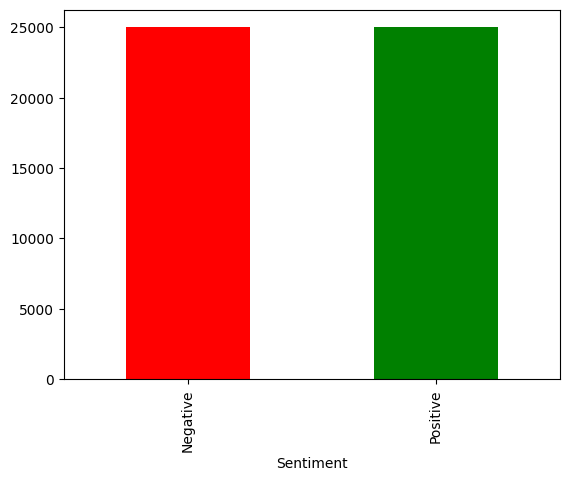

In [ ]:
# Initial Data Exploration
#Plot of class counts 50/50 split
imdb_df['sentiment']= imdb_df['sentiment'].replace({ 'negative':0, 'positive' :1})
class_balance= imdb_df['sentiment'].value_counts()
ax= class_balance.plot(kind='bar', color= ['Red', 'Green'])
ax.set_xticklabels(['Negative', 'Positive'])
plt.xlabel('Sentiment')


In [ ]:
# Calculate average length of comment and average number of words per comment prior to scrubbing
total_len_old = 0
total_words_old = 0
num_rows = len(imdb_df)
for comment in imdb_df['review']:
  total_len_old += len(comment)
  total_words_old += len(comment.split())
avg_len_old = total_len_old/num_rows
avg_words_old = total_words_old/num_rows

In [ ]:
#cleaning process
# scrub text to remove special characters
before_process= imdb_df.iloc[4]['review']
print(before_process)
imdb_df['review']= (
    imdb_df['review']
    .str.replace('[,\.!?:()"]', '', regex=True)
    .str.replace('<.*?>', ' ' , regex= True)
    .str.replace('http\S+', ' ', regex=True)
    .str.replace('[^a-zA-Z0-9]', ' ', regex=True)
    .str.replace('\s+', ' ', regex=True)
    .str.lower()
    .str.strip()
)


after_process= imdb_df.iloc[4]['review']
print(after_process) #Comparing a random review (index 4), before and after cleaning the data

Petter Mattei's "Love in the Time of Money" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what money, power and success do to people in the different situations we encounter. <br /><br />This being a variation on the Arthur Schnitzler's play about the same theme, the director transfers the action to the present time New York where all these different characters meet and connect. Each one is connected in one way, or another to the next person, but no one seems to know the previous point of contact. Stylishly, the film has a sophisticated luxurious look. We are taken to see how these people live and the world they live in their own habitat.<br /><br />The only thing one gets out of all these souls in the picture is the different stages of loneliness each one inhabits. A big city is not exactly the best place in which human relations find sincere fulfillment, as one discerns is the case with m

In [ ]:
# tokenize the data
sw_set = set(nltk.corpus.stopwords.words('english'))

def sw_remove(x):
    words = nltk.tokenize.word_tokenize(x)
    filtered_list = [word for word in words if word not in sw_set]
    return ' '.join(filtered_list)

imdb_df['review'] = imdb_df['review'].apply(lambda x: sw_remove(x))
after_tokenize= imdb_df.iloc[4]['review']
print(after_tokenize)

petter mattei love time money visually stunning film watch mr mattei offers us vivid portrait human relations movie seems telling us money power success people different situations encounter variation arthur schnitzler play theme director transfers action present time new york different characters meet connect one connected one way another next person one seems know previous point contact stylishly film sophisticated luxurious look taken see people live world live habitat thing one gets souls picture different stages loneliness one inhabits big city exactly best place human relations find sincere fulfillment one discerns case people encounter acting good mr mattei direction steve buscemi rosario dawson carol kane michael imperioli adrian grenier rest talented cast make characters come alive wish mr mattei good luck await anxiously next work


In [ ]:
after_tokenize = imdb_df.iloc[9435]['review']
print(after_tokenize)

pure gothic vampire cheese nothing compare subspecies films highly recommend every one


In [ ]:
# Size of text corpus before and after scrubbing
total_len_new = 0
total_words_new = 0
num_rows = len(imdb_df)
for comment in imdb_df['review']:
  total_len_new += len(comment)
  total_words_new += len(comment.split())
avg_len_new = total_len_new/num_rows
avg_words_new = total_words_new/num_rows
print("Average length of comment prior to scrubbing: ", str(avg_len_old))
print("Average number of words per comment prior to scrubbing: ", str(avg_words_old))
print("Average length of comment after scrubbing: ", str(avg_len_new))
print("Average number of words per comment after scrubbing: ", str(avg_words_new))

Average length of comment prior to scrubbing:  819.49708
Average number of words per comment prior to scrubbing:  119.32778
Average length of comment after scrubbing:  819.49708
Average number of words per comment after scrubbing:  119.32778


In [ ]:
# method to get ngrams for a sequence of words
def get_ngrams(sequence, n):
    """
    returns list of n-grams, where each ngram is represented by a tuple of size = n
    """
    sequence_copy = sequence.copy()
    sequence_copy.append('STOP')
    initial_list = []
    n_gram_list = []
    seq_len = len(sequence_copy)

    initial_list.extend([sequence_copy[0:0 + i] for i in range(1, min(n, seq_len+1), 1)])

    # pad lists with 'START'
    for n_gram in initial_list:
        num_starts = n - len(n_gram)
        start_list = ['START'] * num_starts
        n_gram_list.append(start_list + n_gram)

    if n == 1:
        n_gram_list.append(['START'])

    if seq_len >= n:
        n_gram_list.extend([sequence_copy[i:i+n] for i in range(0, seq_len-n+1, 1)])

    n_gram_list = [tuple(x) for x in n_gram_list]
    return n_gram_list

In [ ]:
# Processing into unigrams, bigrams, and trigrams
unigrams = {}
bigrams = {}
trigrams = {}

for comment in imdb_df['review']:
  sequence = comment.split()
  uni_gram_list = get_ngrams(sequence, 1)
  for uni_gram in uni_gram_list:
    count = 0
    if uni_gram in unigrams.keys():
      count = unigrams[uni_gram]
    unigrams[uni_gram] = count + 1

  bi_gram_list = get_ngrams(sequence, 2)
  for bi_gram in bi_gram_list:
    count = 0
    if bi_gram in bigrams.keys():
      count = bigrams[bi_gram]
    bigrams[bi_gram] = count + 1

  tri_gram_list = get_ngrams(sequence, 3)
  for tri_gram in tri_gram_list:
    count = 0
    if tri_gram in trigrams.keys():
      count = trigrams[tri_gram]
    trigrams[tri_gram] = count + 1


In [ ]:
# Number of unique tokens (unigrams), bigrams, and trigrams
print("Total number of unique tokens: ", str(len(unigrams.keys())))
print("Total number of unique bigrams: ", str(len(bigrams.keys())))
print("Total number of unique trigrams: ", str(len(trigrams.keys())))


Total number of unique tokens:  125793
Total number of unique bigrams:  3184488
Total number of unique trigrams:  5524069


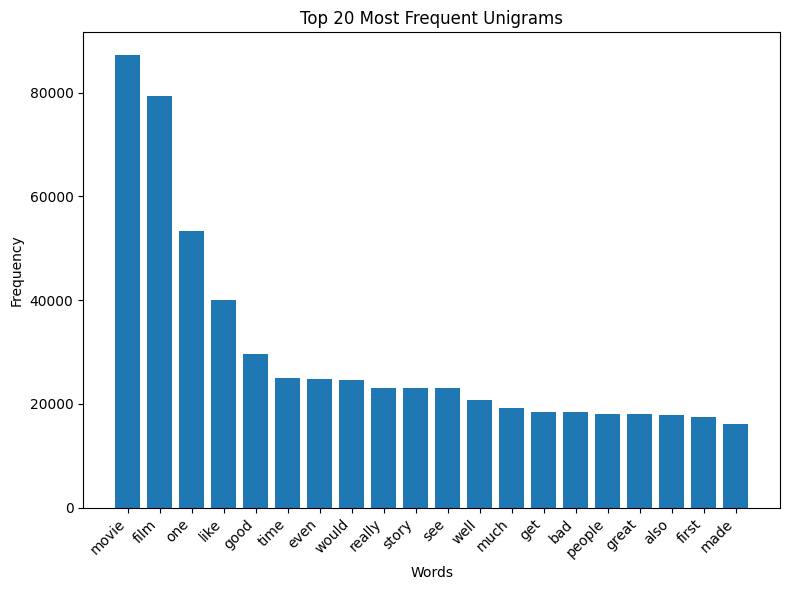

In [ ]:
# top 20 unigrams
sorted_unigrams = sorted(unigrams.items(), key=lambda x: x[1], reverse=True)

top_20 = []
word_labels = []
word_counts = []
for k, v in sorted_unigrams:
  if 'STOP' not in k and 'START' not in k:
    word_labels.append(k[0])
    word_counts.append(v)
  if len(word_counts) == 20:
    break

# Plot the top 20 unigrams
plt.figure(figsize=(8, 6))
plt.bar(word_labels, word_counts)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Top 20 Most Frequent Unigrams")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

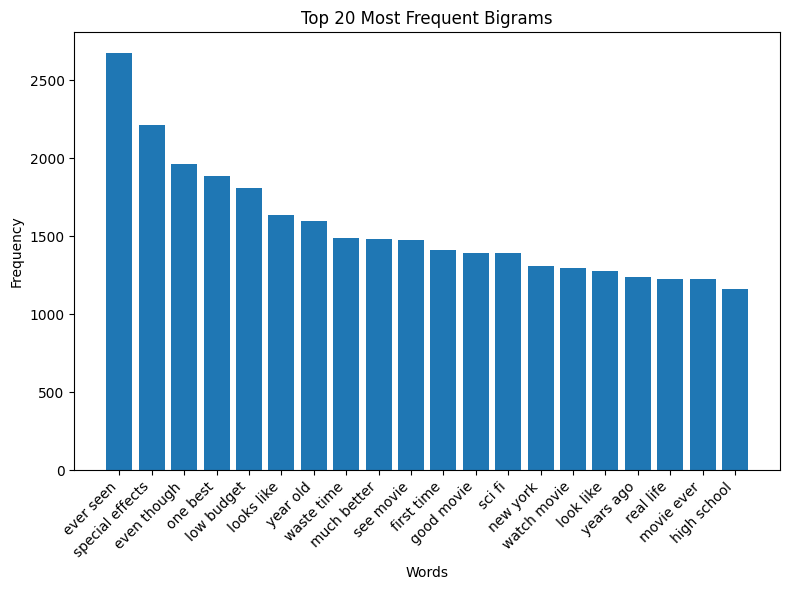

In [ ]:
# top 20 bigrams
sorted_bigrams = sorted(bigrams.items(), key=lambda x: x[1], reverse=True)

top_20 = []
word_labels = []
word_counts = []
for k, v in sorted_bigrams:
  if 'STOP' not in k and 'START' not in k:
    word_labels.append(k[0] + " " + k[1])
    word_counts.append(v)
  if len(word_counts) == 20:
    break

# Plot the top 20 bigrams
plt.figure(figsize=(8, 6))
plt.bar(word_labels, word_counts)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Top 20 Most Frequent Bigrams")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

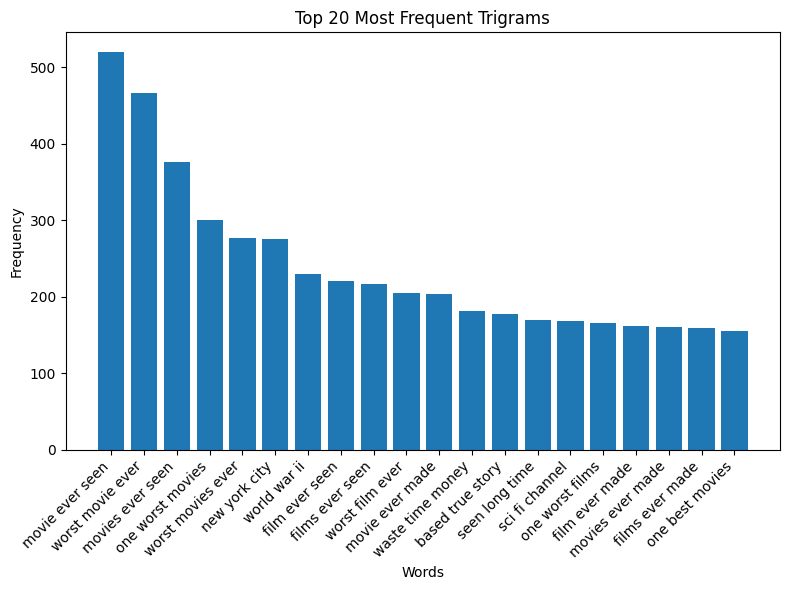

In [ ]:
# top 20 trigrams
sorted_trigrams = sorted(trigrams.items(), key=lambda x: x[1], reverse=True)

top_20 = []
word_labels = []
word_counts = []
for k, v in sorted_trigrams:
  if 'STOP' not in k and 'START' not in k:
    word_labels.append(k[0] + " " + k[1] + " " + k[2])
    word_counts.append(v)
  if len(word_counts) == 20:
    break

# Plot the top 20 trigrams
plt.figure(figsize=(8, 6))
plt.bar(word_labels, word_counts)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Top 20 Most Frequent Trigrams")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

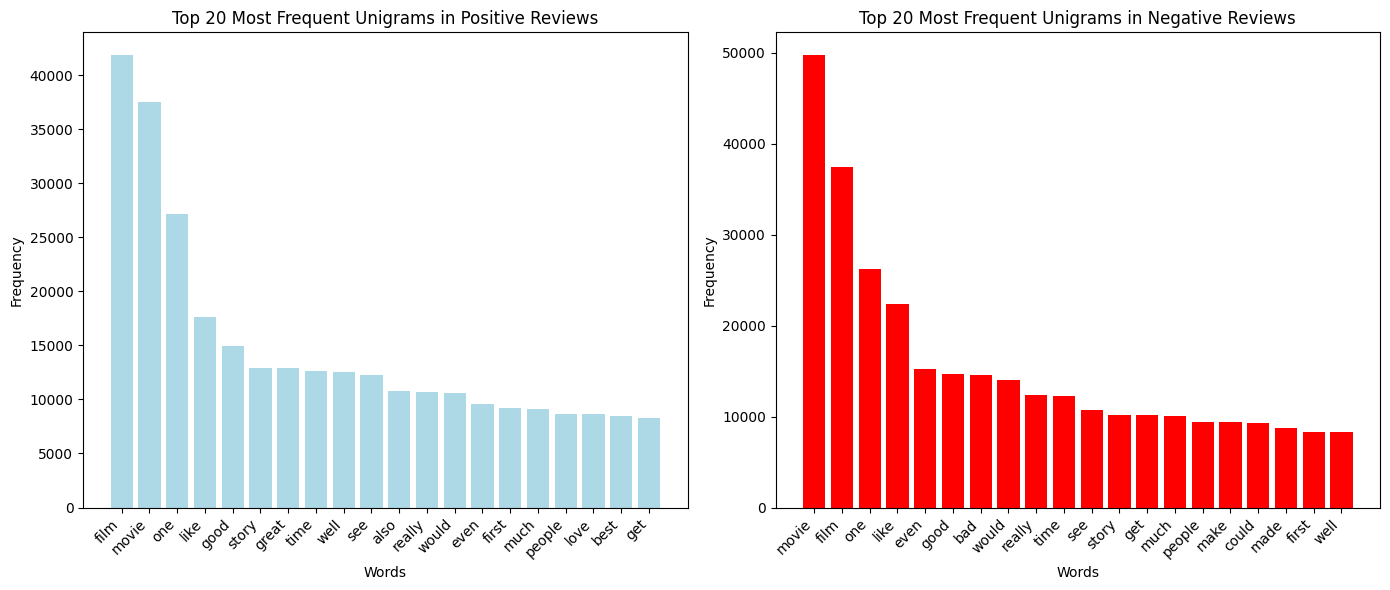

In [ ]:
#top 20 unigrams positive vs negative
positive_reviews = imdb_df[imdb_df['sentiment'] == 1]['review']
negative_reviews = imdb_df[imdb_df['sentiment'] == 0]['review']

def generate_unigrams(reviews):
    unigrams = {}
    for review in reviews:
        sequence = review.split()
        uni_gram_list = get_ngrams(sequence, 1)
        for uni_gram in uni_gram_list:
            if 'STOP' not in uni_gram and 'START' not in uni_gram:
                unigrams[uni_gram] = unigrams.get(uni_gram, 0) + 1
    return unigrams

positive_unigrams=generate_unigrams(positive_reviews)
negative_unigrams=generate_unigrams(negative_reviews)

def get_top_unigrams(unigram_dict, top_n=20):
    sorted_unigrams = sorted(unigram_dict.items(), key=lambda x: x[1], reverse=True)
    word_labels = [k[0] for k, v in sorted_unigrams[:top_n]]
    word_counts = [v for k, v in sorted_unigrams[:top_n]]
    return word_labels, word_counts

top_positive_words, top_positive_counts = get_top_unigrams(positive_unigrams, 20)
top_negative_words, top_negative_counts = get_top_unigrams(negative_unigrams, 20)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.bar(top_positive_words, top_positive_counts, color='lightblue')
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Top 20 Most Frequent Unigrams in Positive Reviews")
plt.xticks(rotation=45, ha="right")


plt.subplot(1, 2, 2)
plt.bar(top_negative_words, top_negative_counts, color='red')
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Top 20 Most Frequent Unigrams in Negative Reviews")
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()

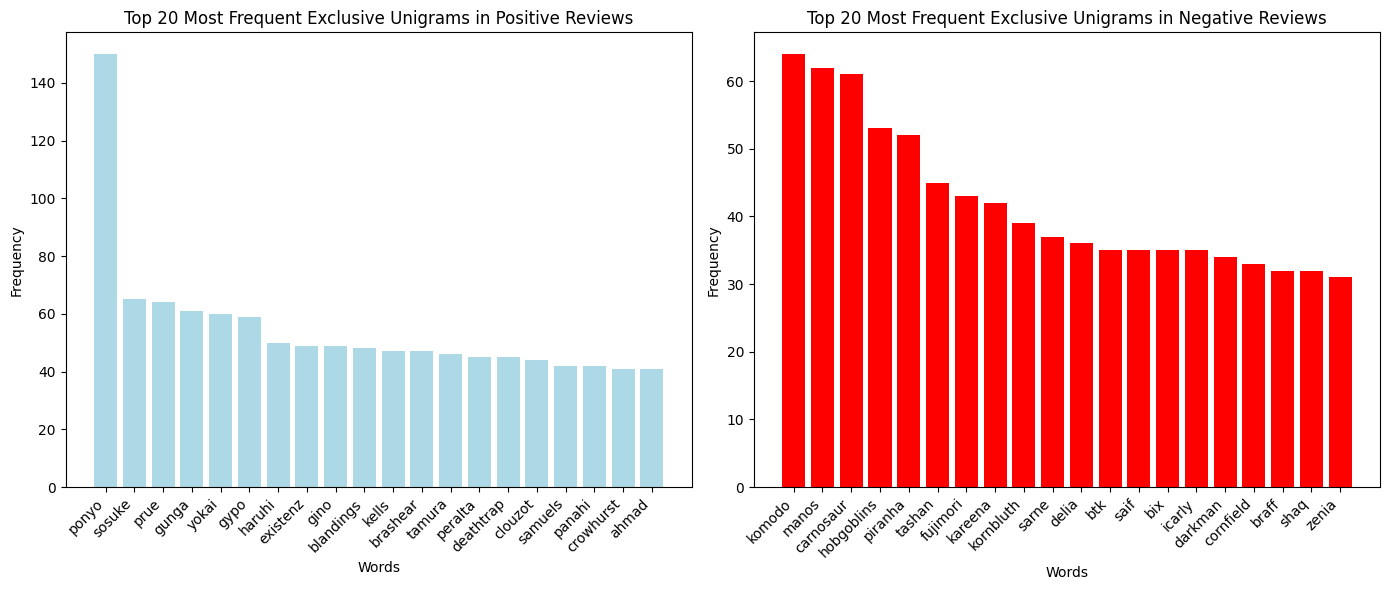

In [ ]:
#Unigram plot for top 20 words exclusively in each category
#separate unigrams
pos_unigrams= generate_unigrams(positive_reviews)
neg_unigrams= generate_unigrams(negative_reviews)

# exclude common words
common_words=set(pos_unigrams.keys()).intersection(set(neg_unigrams.keys()))
exclusive_pos_unigrams = {k: v for k, v in pos_unigrams.items() if k not in common_words}
exclusive_neg_unigrams = {k: v for k, v in neg_unigrams.items() if k not in common_words}

exclusive_positive, positive_counts = get_top_unigrams(exclusive_pos_unigrams, 20)
exclusive_negative, negative_counts = get_top_unigrams(exclusive_neg_unigrams, 20)
plt.figure(figsize=(14, 6))

plt.subplot(1,2,1)
plt.bar(exclusive_positive, positive_counts, color='lightblue')
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Top 20 Most Frequent Exclusive Unigrams in Positive Reviews")
plt.xticks(rotation=45, ha="right")

#Plot2
plt.subplot(1, 2, 2)
plt.bar(exclusive_negative, negative_counts, color='red')
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Top 20 Most Frequent Exclusive Unigrams in Negative Reviews")
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()

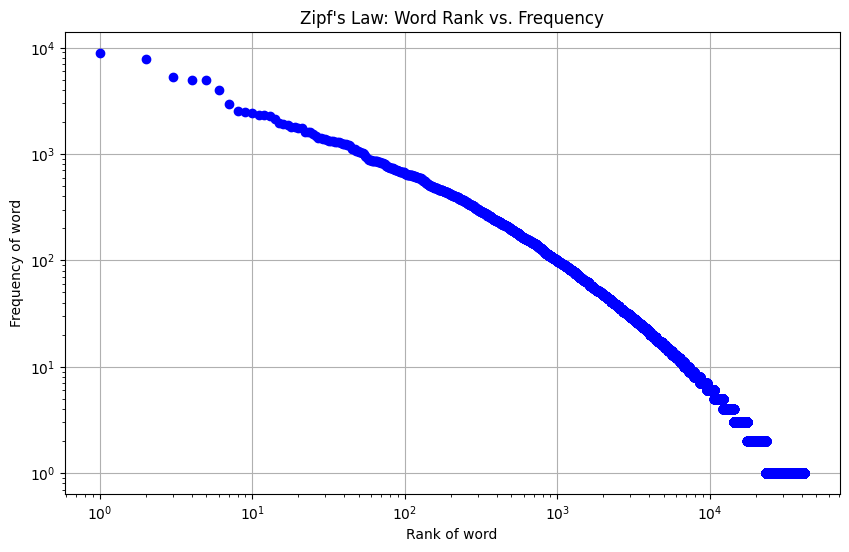

In [ ]:
# Zipf's Law Graphs
# get sorted list of num times a word occurs
frequencies = np.array(sorted(unigrams.values(), reverse=True))

# get corrsponding rank for each word
ranks = np.arange(1, len(frequencies) + 1)

plt.figure(figsize=(10, 6))
plt.loglog(ranks, frequencies, marker="o", linestyle="none", color="b")
plt.title("Zipf's Law: Word Rank vs. Frequency")
plt.xlabel("Rank of word")
plt.ylabel("Frequency of word")
plt.grid(True)
plt.show()

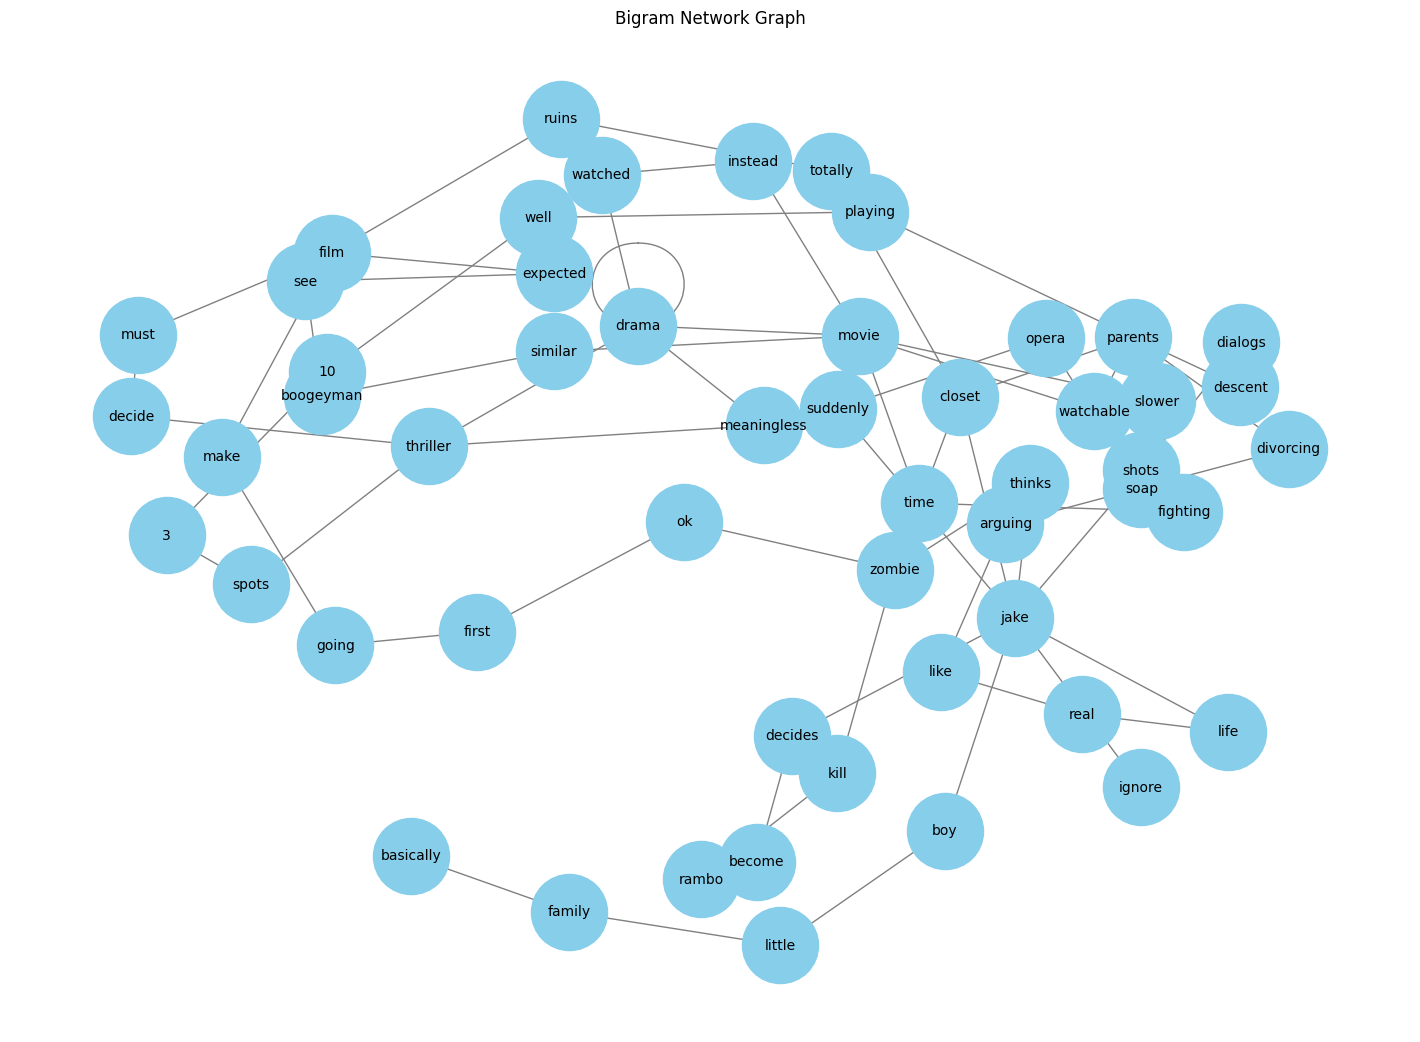

In [ ]:
import re
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import bigrams
import nltk
text = imdb_df['review'][3]

text = re.sub(r'\W+', ' ', text.lower())
tokens = word_tokenize(text)
tokens = [word for word in tokens if word not in stopwords.words('english')]

# Generate bigrams
bigram_list = list(bigrams(tokens))
bigram_counts = Counter(bigram_list)

# Create the bigram network
G = nx.Graph()
for (word1, word2), freq in bigram_counts.items():
    G.add_edge(word1, word2, weight=freq)

# Draw the network
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=0.5)
edges = G.edges(data=True)
weights = [edge[2]['weight'] for edge in edges]

nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', edge_color='gray', width=weights, font_size=10)
plt.title('Bigram Network Graph')
plt.show()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


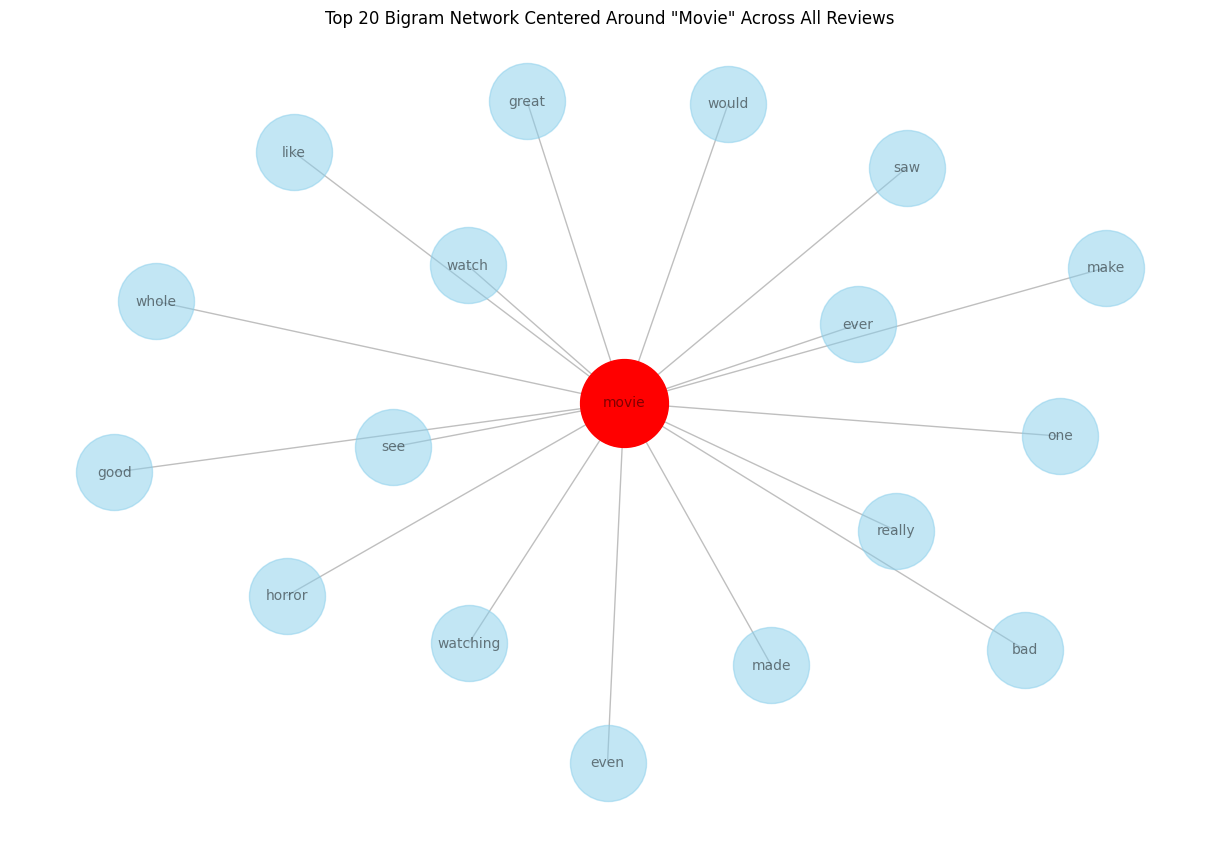

In [ ]:
import networkx as nx
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import bigrams
import nltk
nltk.download('punkt_tab')

all_reviews_text = ' '.join(imdb_df['review'].tolist())

# Preprocess the combined text
all_reviews_text = re.sub(r'\W+', ' ', all_reviews_text.lower())
tokens = word_tokenize(all_reviews_text)
tokens = [word for word in tokens if word not in stopwords.words('english')]

# Generate bigrams and count their occurrences
bigram_list = list(bigrams(tokens))
bigram_counts = Counter(bigram_list)

# Filter bigrams to only include those connected to "movie" and get the top 20 by frequency
filtered_bigrams = {bigram: count for bigram, count in bigram_counts.items() if "movie" in bigram}
top_bigrams = dict(Counter(filtered_bigrams).most_common(20))  # Adjust number here for more or fewer bigrams

# Create the bigram network centered on "movie"
G = nx.Graph()
for (word1, word2), freq in top_bigrams.items():
    # Only add bigrams that include "movie"
    if word1 == "movie" or word2 == "movie":
        G.add_edge(word1, word2, weight=freq)

# Draw the network
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.8)  # Adjust k to spread nodes
edges = G.edges(data=True)

# Draw the graph with "movie" as the central node
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', edge_color='gray',width=1, alpha=0.5, font_size=10)
nx.draw_networkx_nodes(G, pos, nodelist=["movie"], node_size=4000, node_color='red')  # Highlight "movie" in red

plt.title('Top 20 Bigram Network Centered Around "Movie" Across All Reviews')
plt.show()